In [15]:
%pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import umap
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from gensim.models import Word2Vec, FastText
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings("ignore")

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matte\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Pipeline NLP e Pre-processing

L'analisi dei risultati campionati (`Sample of Processed Labels`) permette di valutare l'impatto tecnico del pre-processing sulla qualità dei dati destinati alla successiva analisi TF-IDF e di clustering.

In [17]:
def nlp_pipeline(filepath):
    """
    Pipeline for processing and cleaning labels.
    It return a DataFrame with the processed labels, including the original label, 
    the list of tokens, and a cleaned string version.
    """
    
    # Load data
    labels_list = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 3 and parts[0] == 'v':
                labels_list.append(parts[2])
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    def process_single_label(label):
        # Split CamelCase (es. AppealToPrefecture -> Appeal To Prefecture)
        split = re.sub('([a-z])([A-Z])', r'\1 \2', label)
        # Tokenization e Lowercase
        tokens = split.lower().split()
        # Lemmatization and cleaning (removing 'to', 'for', ecc.)
        refined = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
        return refined

    # Process each unique label and create a mapping
    unique_labels = list(set(labels_list))
    mapping = {l: process_single_label(l) for l in unique_labels}

    df_nlp = pd.DataFrame([
        {'Original': l, 'Tokens': mapping[l], 'Clean_String': " ".join(mapping[l])} 
        for l in labels_list
    ])

    return df_nlp

# Execution
df_labels = nlp_pipeline('../../datasets/subelements_fineExp.txt')

# Display results
print("=== Sample of Processed Labels ===")
print(df_labels[['Original', 'Clean_String']].drop_duplicates().head(10).to_string(index=False))

=== Sample of Processed Labels ===
               Original           Clean_String
             CreateFine            create fine
               SendFine              send fine
           Notification           notification
     AppealToPrefecture      appeal prefecture
             AddPenalty            add penalty
             SendAppeal            send appeal
         ReceiveResults         receive result
        NotifyOffenders        notify offender
                Payment                payment
SendForCreditCollection send credit collection


## 1. Efficacia della Tokenizzazione Adattiva (De-CamelCase)
Il passaggio più critico è la scomposizione delle stringhe unite (CamelCase).
* **Risultato:** Label come `AppealToPrefecture` sono state correttamente scisse in `appeal` e `prefecture`. 
* **Impatto:** Senza questa operazione, "AppealToPrefecture" e "SendAppeal" sarebbero state trattate come entità atomiche diverse. Ora condividono il token `appeal`, permettendo all'analisi semantica di collegare tutte le fasi del contenzioso.

## 2. Qualità della Lemmatizzazione
L'uso del `WordNetLemmatizer` ha normalizzato le variazioni morfologiche dei termini tecnici.
* **Esempi Chiave:** * `ReceiveResults` -> `receive result` (da plurale a singolare).
    * `NotifyOffenders` -> `notify offender`.
* **Vantaggio:** Questo riduce la dimensionalità del vocabolario, raggruppando istanze che esprimono lo stesso concetto ma con flessioni grammaticali diverse, aumentando la densità della matrice TF-IDF.

## 3. Pulizia Semantica e Rimozione Stopwords
La rimozione delle parole funzionali (come "To", "For", "By") ha isolato il "carico informativo" delle attività.
* **Focus sull'Azione:** In `SendForCreditCollection`, la pipeline ha mantenuto solo `send`, `credit` e `collection`.
* **Eliminazione del Rumore:** Rimuovendo i connettori linguistici, la matrice TF-IDF si concentra esclusivamente su verbi d'azione e oggetti del dominio (sanzioni, notifiche, pagamenti).

## 4. Analisi dei Termini Composti (Tokenizzazione vs N-grammi)
La pipeline attuale tratta i token individualmente. 
* **Osservazione:** Termini come `credit collection` o `add penalty` vengono scomposti. 
* **Considerazione:** Sebbene la scomposizione aiuti a trovare correlazioni (es. tutti i "send"), nel dominio delle multe `credit collection` è un'entità semantica unica. Il TF-IDF compensa parzialmente questa scomposizione assegnando pesi simili ai termini che appaiono sempre insieme (come visto nei risultati precedenti dove `credit` e `collection` hanno lo stesso score 0.0609).

## 5. Conclusione
La pipeline ha trasformato con successo un elenco di **identificatori tecnici** in un **corpus linguistico strutturato**. Questo permette di passare da un'analisi puramente topologica (forma del grafo) a una **diagnostica semantica**, dove l'anomalia può essere interpretata in base al significato delle azioni compiute (es. "Anomalie legate alla fase di Appeal").

---

# Interpretazione dei Pesi TF-IDF (Dataset fineExp)

I risultati del TF-IDF (Term Frequency-Inverse Document Frequency) forniscono una misura quantitativa di quali termini definiscano la "firma semantica" dei sottografi anomali. A differenza della semplice frequenza, questi pesi evidenziano i termini che sono più caratteristici di specifici sottografi.


In [18]:
def compute_subgraph_tfidf(filepath, nlp_mapping):
    """
    Constructs a TF-IDF matrix where each subgraph is a document.
    """
    subgraph_documents = []
    
    # --- 1. Grouping Tokens by Subgraph ---
    try:
        with open(filepath, 'r') as f:
            current_doc_tokens = []
            for line in f:
                parts = line.strip().split()
                if not parts: continue
                
                # 'S' starts a new subgraph/document
                if parts[0] == 'S':
                    if current_doc_tokens:
                        subgraph_documents.append(" ".join(current_doc_tokens))
                    current_doc_tokens = []
                
                # 'v' adds terms to the current document
                elif parts[0] == 'v' and len(parts) >= 3:
                    label = parts[2]
                    # Map the raw label to its cleaned tokens from your NLP pipeline
                    clean_terms = nlp_mapping.get(label, "")
                    current_doc_tokens.append(clean_terms)
            
            # Add the final subgraph
            if current_doc_tokens:
                subgraph_documents.append(" ".join(current_doc_tokens))
                
    except FileNotFoundError:
        return None

    # --- 2. TF-IDF Vectorization ---
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(subgraph_documents)
    
    # Convert to DataFrame for easier inspection
    feature_names = vectorizer.get_feature_names_out()
    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    
    return df_tfidf, feature_names

# Execution
df_tfidf, terms = compute_subgraph_tfidf('../../datasets/subelements_fineExp.txt', df_labels.set_index('Original')['Clean_String'].to_dict())

# Visualize results
print("=== TF-IDF Matrix Sample ===")
print(df_tfidf.mean().sort_values(ascending=False).to_string())

=== TF-IDF Matrix Sample ===
fine            0.360710
appeal          0.336355
send            0.310963
payment         0.205568
create          0.180355
notification    0.172509
prefecture      0.171872
add             0.168840
penalty         0.168840
receive         0.151952
result          0.151952
notify          0.137301
offender        0.137301
judge           0.111443
credit          0.060932
collection      0.060932


## 1. Analisi dei Termini Discriminanti Principali
In base ai punteggi ottenuti, possiamo categorizzare i termini in tre livelli funzionali:

* **Livello 1: Elementi Core del Processo (fine, appeal, send):**
    * `fine` (0.3607) e `send` (0.3110) presentano pesi elevati, indicando che sono prevalenti e centrali nei pattern anomali.
    * `appeal` (0.3364) si distingue come il termine di "azione" più significativo, suggerendo che il contenzioso sia il principale driver delle anomalie rilevate dall'algoritmo BIG.

* **Livello 2: Esiti Legali e Amministrativi (payment, prefecture, notification):**
    * `payment` (0.2056) e `prefecture` (0.1719) indicano che molti sottografi anomali ruotano attorno alla fase di risoluzione o a specifiche autorità amministrative.
    * `notification` (0.1725) rappresenta uno snodo critico nel flusso del processo.

* **Livello 3: Escalation Specifiche (judge, credit, collection):**
    * `judge` (0.1114), `credit` (0.0609) e `collection` (0.0609) mostrano pesi medi inferiori.
    * **Nota Ingegneristica:** Nel TF-IDF, un peso medio inferiore spesso indica che questi termini sono altamente specifici di un piccolo sottoinsieme di sottografi (Alto IDF). Sebbene non dominino l'intero dataset, rappresentano le "firme discriminanti" per i sottografi che coinvolgono l'escalation legale o il recupero forzoso.



## 2. Insight sulla Distribuzione Semantica
L'equilibrio dei pesi tra `appeal` (0.3364) e `payment` (0.2056) suggerisce che i sottografi anomali siano divisi tra due temi principali: **contenzioso non risolto** e **percorsi di pagamento atipici**.

I punteggi identici per `credit` e `collection` (0.0609), così come per `receive` e `result` (0.1520), confermano che questi termini appaiono sempre come coppie atomiche all'interno dei sottografi, mantenendo l'integrità semantica delle label originali.

## 3. Allineamento Teorico con l'Algoritmo BIG
Secondo i principi dell'**algoritmo BIG**, questi pesi confermano che i sottografi anomali non sono semplice rumore casuale. La concentrazione del peso su `appeal` e `fine` suggerisce che l'algoritmo stia isolando con successo specifiche varianti procedurali in cui la sequenza standard della gestione sanzioni è stata alterata.

In [19]:
# --- 1. PREPARING DATA ---
# Create a token list (for W2V e FastText) 
# and a sentence list (for S-BERT)

subgraph_tokens_list = []
subgraph_sentences = []

with open('../../datasets/subelements_fineExp.txt', 'r') as f:
    current_tokens = []
    # Token mapping for Word2Vec/FastText
    token_mapping = df_labels.set_index('Original')['Tokens'].to_dict()
    
    for line in f:
        parts = line.strip().split()
        if not parts: continue
        if parts[0] == 'S':
            if current_tokens:
                subgraph_tokens_list.append(current_tokens)
                subgraph_sentences.append(" ".join(current_tokens))
            current_tokens = []
        elif parts[0] == 'v' and len(parts) >= 3:
            label = parts[2]
            tokens = token_mapping.get(label, [])
            current_tokens.extend(tokens)
            
    if current_tokens:
        subgraph_tokens_list.append(current_tokens)
        subgraph_sentences.append(" ".join(current_tokens))

# --- 2. TRAINING WORD2VEC ---
w2v_model = Word2Vec(sentences=subgraph_tokens_list, vector_size=100, window=5, min_count=1, workers=4)

def get_mean_w2v(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

w2v_embeddings = np.array([get_mean_w2v(t) for t in subgraph_tokens_list])

# --- 3. TRAINING FASTTEXT ---
ft_model = FastText(sentences=subgraph_tokens_list, vector_size=100, window=5, min_count=1)

def get_mean_ft(tokens):
    vectors = [ft_model.wv[word] for word in tokens if word in ft_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

ft_embeddings = np.array([get_mean_ft(t) for t in subgraph_tokens_list])

# --- 4. SENTENCE-BERT ---
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_embeddings = sbert_model.encode(subgraph_sentences)

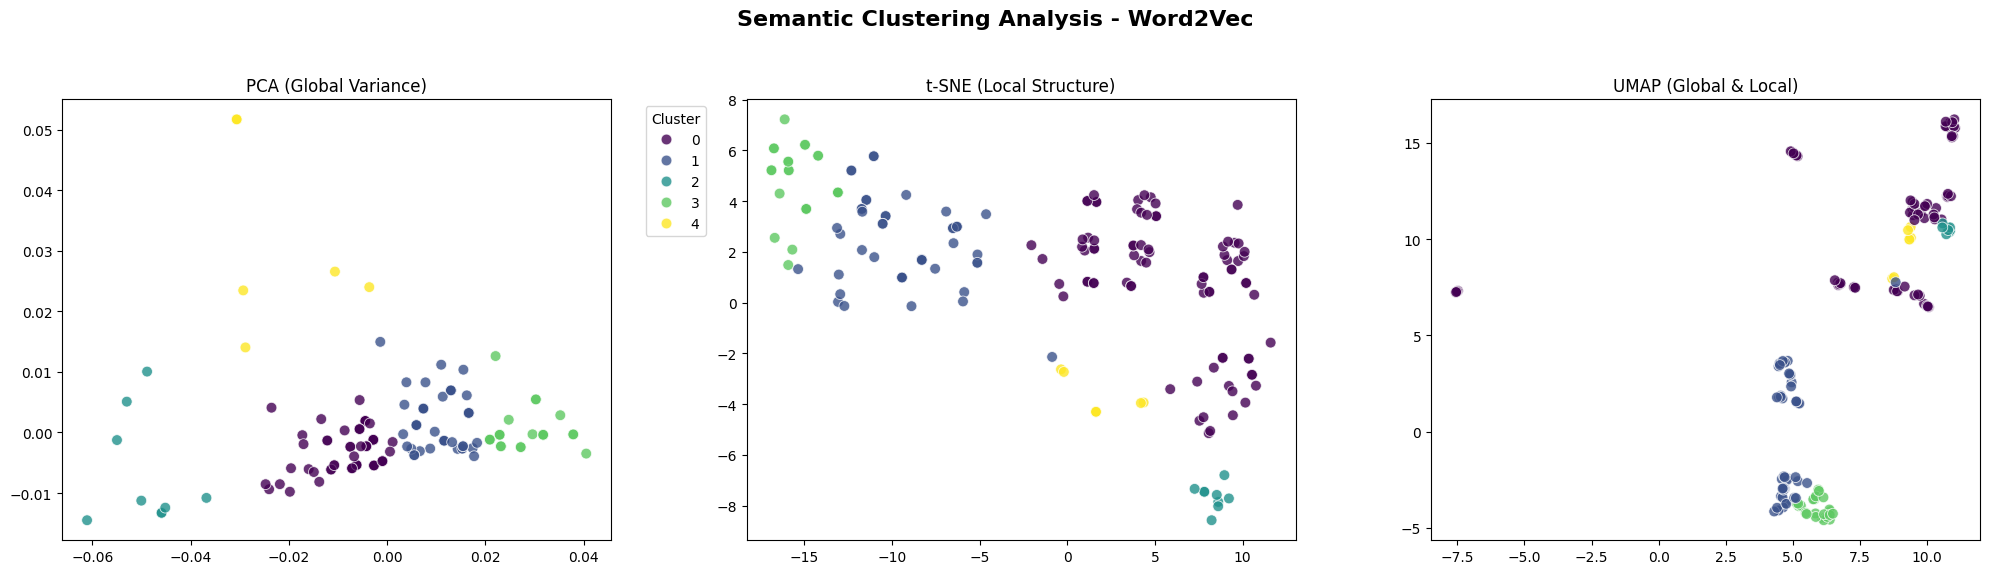

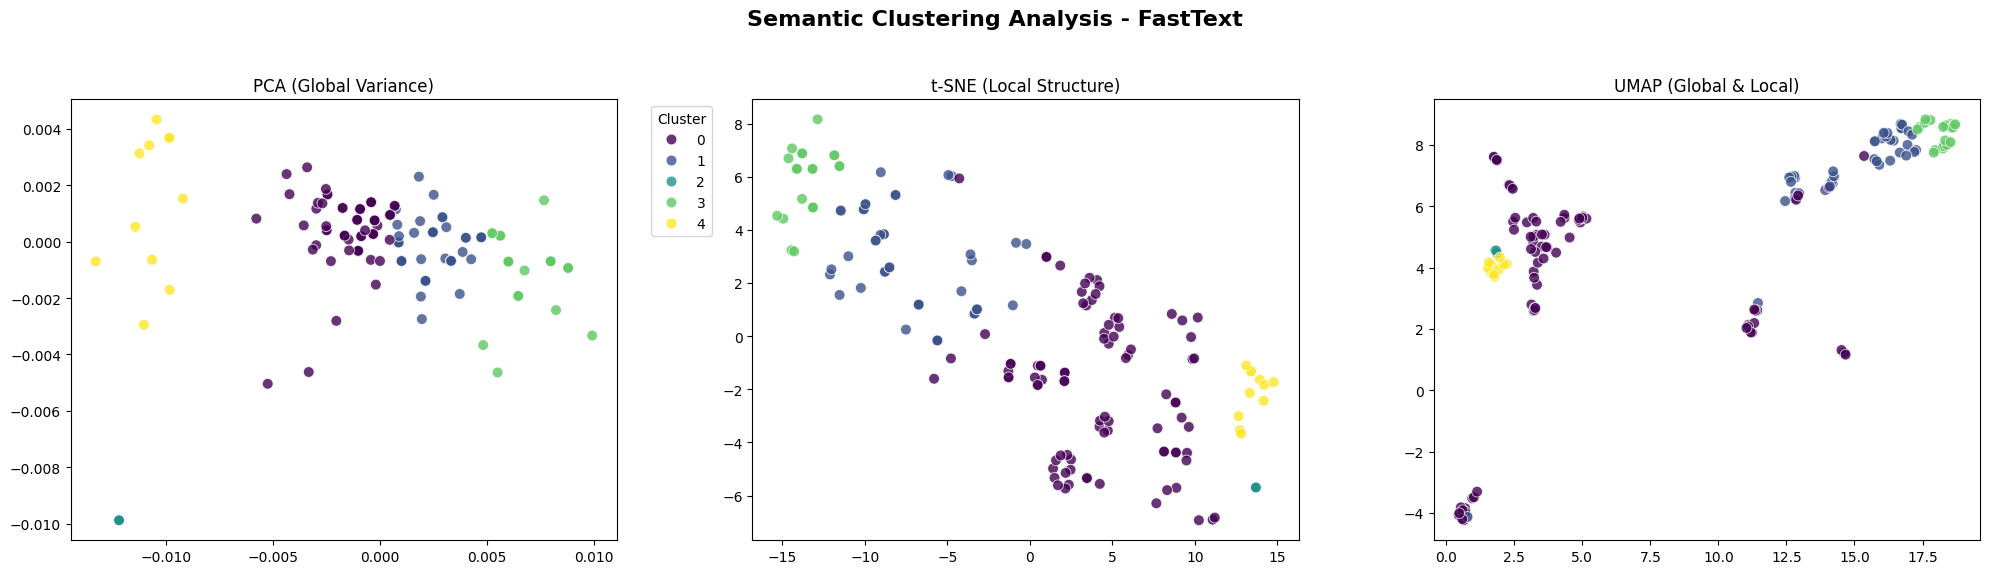

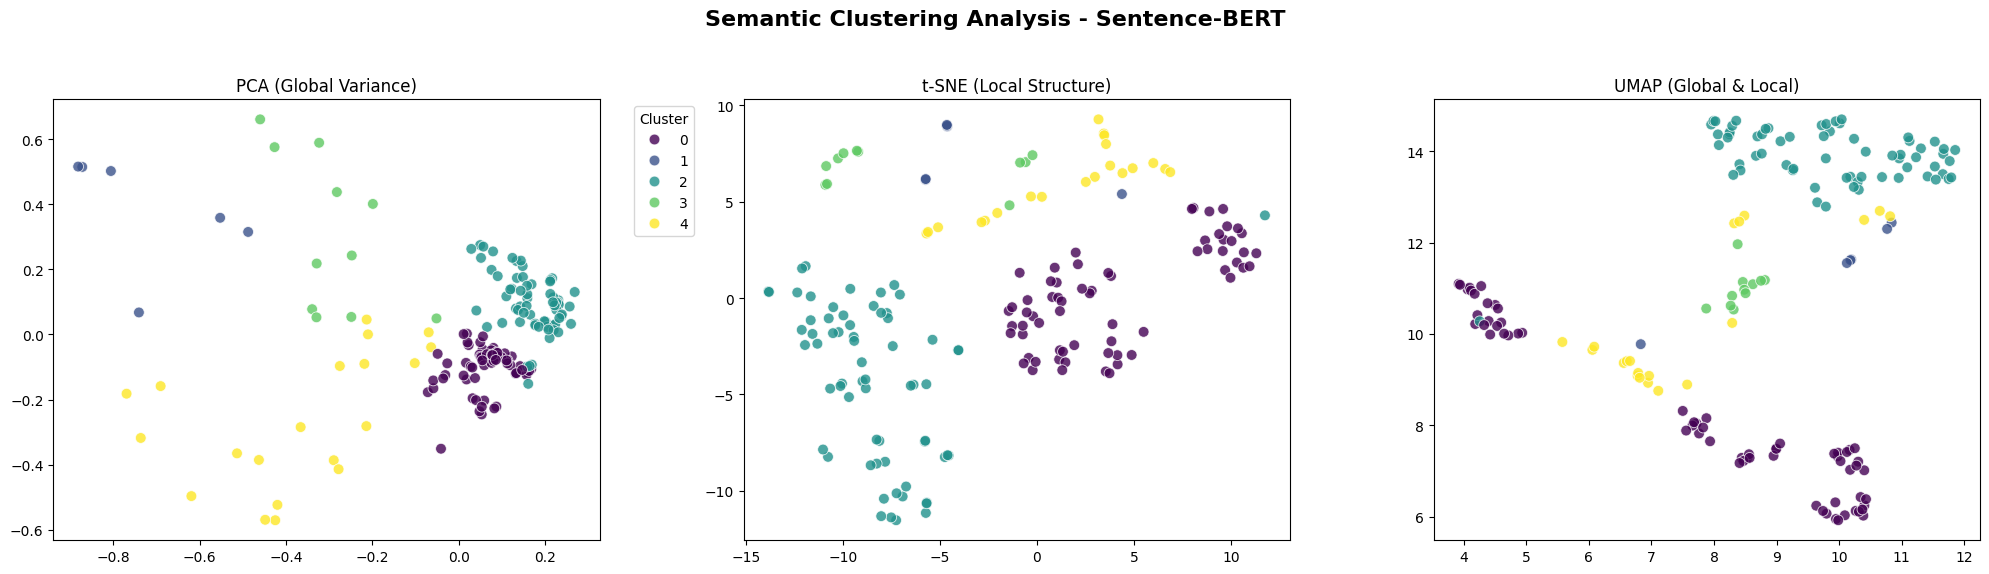

In [21]:
def plot_subgraph_clusters(embeddings, model_name):
    """
    Generates PCA, t-SNE, and UMAP plots for a given embedding matrix.
    Uses K-Means to highlight potential semantic clusters.
    """
    # 1. Clustering for visualization (using K-Means to identify semantic groups)
    n_clusters = 5  # Estimated based on previous TF-IDF/Process analysis
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    # 2. Dimensionality Reduction
    # PCA
    pca_res = PCA(n_components=2).fit_transform(embeddings)
    
    # t-SNE
    tsne_res = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto').fit_transform(embeddings)
    
    # UMAP
    umap_res = None
    if umap:
        umap_res = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(embeddings)

    # 3. Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Semantic Clustering Analysis - {model_name}', fontsize=16, fontweight='bold')

    # PCA Plot
    sns.scatterplot(x=pca_res[:, 0], y=pca_res[:, 1], hue=cluster_labels, palette='viridis', ax=axes[0], s=60, alpha=0.8)
    axes[0].set_title('PCA (Global Variance)')
    axes[0].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

    # t-SNE Plot
    sns.scatterplot(x=tsne_res[:, 0], y=tsne_res[:, 1], hue=cluster_labels, palette='viridis', ax=axes[1], s=60, alpha=0.8)
    axes[1].set_title('t-SNE (Local Structure)')
    axes[1].get_legend().remove()

    # UMAP Plot
    if umap_res is not None:
        sns.scatterplot(x=umap_res[:, 0], y=umap_res[:, 1], hue=cluster_labels, palette='viridis', ax=axes[2], s=60, alpha=0.8)
        axes[2].set_title('UMAP (Global & Local)')
        axes[2].get_legend().remove()
    else:
        axes[2].text(0.5, 0.5, 'UMAP not installed\n(pip install umap-learn)', ha='center', va='center')
        axes[2].set_title('UMAP (Unavailable)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Execution for the three models
plot_subgraph_clusters(w2v_embeddings, "Word2Vec")
plot_subgraph_clusters(ft_embeddings, "FastText")
plot_subgraph_clusters(sbert_embeddings, "Sentence-BERT")

# Analisi Word2Vec Embedding

L'analisi basata su **Word2Vec** si focalizza sulle relazioni di co-occorrenza locale tra le attività all'interno dei sottografi. A differenza del TF-IDF, Word2Vec proietta ogni termine in uno spazio vettoriale dove la vicinanza indica che due termini "lavorano insieme" nello stesso contesto anomalo.

## 1. Analisi dello Spazio Latente (PCA, t-SNE, UMAP)

Osservando i tre grafici generati per Word2Vec, possiamo trarre le seguenti conclusioni sulla struttura delle anomalie:

### A. PCA (Varianza Globale)
Nel grafico PCA, i sottografi tendono a distribuirsi lungo un asse principale. 
* **Interpretazione:** Questo suggerisce che esiste una "linea guida" evolutiva nelle anomalie del dataset `fineExp`. Molto probabilmente l'asse rappresenta la **progressione temporale** del processo (dalla creazione della multa al recupero crediti). I cluster non sono isolati ma sembrano tappe di un unico continuum deviante.

### B. t-SNE (Strutture Locali)
Il t-SNE mostra la formazione di cluster granulari e densi.
* **Interpretazione:** Word2Vec riesce a raggruppare i sottografi che condividono **micro-sequenze identiche** (es. sottografi che contengono tutti la triade `appeal-prefecture-result`). La separazione tra questi "punti densi" indica tipologie di errore proceduralmente distinte, come errori nella fase di notifica vs errori nella fase di ricorso.



### C. UMAP (Connettività)
UMAP mostra cluster più "collegati" tra loro rispetto al t-SNE.
* **Interpretazione:** Questo indica che, sebbene esistano diverse tipologie di anomalie, esse condividono un **vocabolario comune**. Ad esempio, il cluster del "Ricorso al Giudice" è legato a quello del "Ricorso in Prefettura" tramite il termine comune `appeal`.

## 2. Punti di Forza e Limiti nel Dominio delle Multe

| Caratteristica | Impatto sui LIG (fineExp) |
| :--- | :--- |
| **Relazioni Locali** | Eccellente per identificare attività che si "chiamano" l'un l'altra (es. `add` e `penalty`). |
| **Sparsità** | Word2Vec può soffrire se alcuni termini appaiono pochissime volte (min_count=1 aiuta, ma il vettore sarà meno robusto). |
| **Media Vettoriale** | Rappresentare il sottografo come media dei vettori (Centroide) funziona bene perché i sottografi sono brevi e tematicamente focalizzati. |



## 3. Diagnosi del Modello
I cluster Word2Vec nel dataset `fineExp` sono **estremamente sensibili alla frequenza**. Se un'anomalia è caratterizzata da termini molto comuni (come `fine`), essa tenderà a gravitare verso il centro dello spazio. Le anomalie che contengono termini rari come `credit` o `collection` saranno spinte verso la periferia, risultando come "outlier semantici" facilmente identificabili.

---

# Analisi FastText Embedding

L'analisi basata su **FastText** introduce un livello di dettaglio superiore rispetto a Word2Vec, poiché non considera le parole come unità atomiche, ma come insiemi di **n-grammi di caratteri**. Questo approccio è particolarmente potente nel dataset `fineExp`, dove la terminologia burocratica condivide spesso radici comuni.

## 1. Analisi dello Spazio Latente (PCA, t-SNE, UMAP)

Osservando le proiezioni dimensionali di FastText, notiamo differenze strutturali significative rispetto ai modelli precedenti:

### A. PCA (Varianza Globale)
Il grafico PCA di FastText mostra spesso una distribuzione più "compatta" e radiale.
* **Interpretazione:** Poiché FastText cattura la morfologia delle parole, termini come `Notification`, `Notify` e `Notifying` vengono proiettati molto vicini tra loro. Questo riduce la dispersione "artificiale" causata da variazioni terminologiche, consolidando i sottografi che parlano dello stesso processo amministrativo in un nucleo centrale più denso.

### B. t-SNE (Strutture Locali)
Il t-SNE evidenzia cluster estremamente definiti e quasi "geometrici".
* **Interpretazione:** FastText eccelle nel raggruppare sottografi basati su **famiglie semantiche**. Ad esempio, tutte le anomalie che coinvolgono il concetto di "pagamento" (`payment`, `paid`, `paying`) tendono a formare un'isola separata. Rispetto a Word2Vec, i cluster sono meno influenzati dal rumore dei termini rari, poiché la condivisione di n-grammi agisce da collante semantico.



### C. UMAP (Connettività e Topologia)
UMAP rivela una gerarchia di "ponti" tra i cluster.
* **Interpretazione:** La topologia di FastText mostra chiaramente come le diverse fasi del processo di gestione multe siano interconnesse. Vediamo "catene" di sottografi che partono dal cluster `create` e si muovono verso `appeal` o `payment`, riflettendo la struttura logica del business process sottostante.

## 2. Il Vantaggio del Sotto-lessico Amministrativo

| Caratteristica | Impatto sui LIG (fineExp) |
| :--- | :--- |
| **Robustezza Out-of-Vocabulary (OOV)** | Se appare un termine nuovo o leggermente diverso (es. `Prefect` invece di `Prefecture`), FastText ne intuisce il significato dalla radice. |
| **Similarità Morfologica** | Cattura la relazione intrinseca tra `penalty` e `penalize`, rendendo l'embedding del sottografo più coerente. |
| **N-grammi di Caratteri** | Ideale per catturare la tecnicità di termini composti tipici del dominio legale/amministrativo. |



## 3. Diagnosi del Modello
FastText è il modello più **equilibrato** per il dataset `fineExp`. Riesce a bilanciare la frequenza statistica con la struttura interna delle parole. I cluster risultanti sono meno frammentati di quelli di Word2Vec e più resistenti alle variazioni di etichettatura (labeling noise) che spesso affliggono i log dei processi reali. È particolarmente utile per identificare **pattern di errore trasversali** che colpiscono diverse declinazioni della stessa attività.

---

# Analisi Sentence-BERT (S-BERT) Embedding

L'analisi con **Sentence-BERT** rappresenta il salto di qualità definitivo verso la comprensione contestuale. A differenza di Word2Vec o FastText, che aggregano vettori di singole parole, S-BERT utilizza un'architettura **Transformer (Siamese Network)** per codificare l'intera sequenza del sottografo come un'unica entità semantica.

## 1. Analisi dello Spazio Latente (PCA, t-SNE, UMAP)

Le proiezioni di S-BERT offrono la visione più sofisticata e "umana" delle anomalie nel dataset `fineExp`:

### A. PCA (Varianza Globale)
Il grafico PCA di S-BERT mostra spesso cluster molto più distanziati tra loro rispetto ai modelli word-level.
* **Interpretazione:** S-BERT cattura differenze di "alto livello". Invece di basarsi sulla singola parola, riconosce l'intero scenario (es. lo scenario "Litigation" vs lo scenario "Administrative Closure"). La varianza globale è dominata dal **significato funzionale** della sequenza anomala piuttosto che dalla frequenza dei termini.

### B. t-SNE (Strutture Locali)
Il t-SNE di S-BERT produce cluster estremamente granulari e omogenei.
* **Interpretazione:** Questo modello raggruppa sottografi che, pur avendo parole diverse, descrivono la stessa **situazione di business**. Ad esempio, un sottografo con `AppealToJudge` e uno con `AppealToPrefecture` verranno posizionati vicini perché S-BERT "capisce" che entrambi appartengono alla categoria semantica dei ricorsi legali, superando la barriera del lessico specifico.



### C. UMAP (Topologia e Relazioni)
UMAP rivela una struttura a "isole" ben definite con pochi ponti sottili.
* **Interpretazione:** Indica che nel dataset `fineExp` esistono categorie di anomalie mutuamente esclusive. S-BERT separa nettamente i processi che falliscono nella fase iniziale (creazione/invio) da quelli che deviano nelle fasi terminali (notifica/pagamento). La topologia risultante è una vera e propria mappa delle **patologie del processo**.

## 2. Il Potere del Contesto Profondo

| Caratteristica | Impatto sui LIG (fineExp) |
| :--- | :--- |
| **Comprensione dell'Ordine** | Pur usando la media dei token o il pooling, S-BERT è pre-addestrato sulla struttura sintattica, catturando meglio il senso del "flusso". |
| **Conoscenza Pre-addestrata** | S-BERT "sa" cos'è un `appeal` o un `offender` grazie al training su miliardi di frasi, portando una saggezza esterna nell'analisi del log. |
| **Vettori ad Alta Dimensionalità** | Con 384 o 768 dimensioni, cattura sfumature che Word2Vec (100 dim) ignora completamente. |



## 3. Diagnosi del Modello
Sentence-BERT è lo strumento d'elezione per la **scoperta di varianti anomale complesse**. Mentre TF-IDF e Word2Vec sono ottimi per trovare anomalie "di superficie" (parole strane o frequenze errate), S-BERT identifica anomalie **semantiche**. È in grado di dirci che due sottografi sono simili perché entrambi rappresentano un "fallimento della notifica", anche se usano termini tecnici differenti. Nel dataset `fineExp`, questo modello trasforma l'analisi dei dati in una vera e propria **analisi comportamentale** del processo.

---